# EMA Crossover Backtest – Walkthrough

This notebook walks through a simple EMA crossover strategy on SPY.

We will:

1. Load SPY price data.
2. Compute fast and slow EMAs and plot them.
3. Build trading signals and positions.
4. Run a backtest with trading costs.
5. Look at equity, drawdown, and Sharpe ratio.
6. Compare long-only vs long/short and different EMA settings.

In [2]:
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root on path:", project_root)


Project root on path: /Users/thomasthanga/Documents/Projects/ema-backtest


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from src.ema_backtest import (
    get_price_data,
    add_ema_signals,
    run_backtest,
    plot_price,
    plot_signals,
    plot_equity,
    plot_drawdown,
    sweep_ema_params,
    add_atr,
    add_position_sizing,
    add_triple_ema_signals,
    walk_forward_once,
)

plt.rcParams["figure.figsize"] = (12, 6)


## 1. Load SPY data

We start by loading daily price data for SPY from 2015 onward and looking at the raw price series.

In [4]:
df_raw = get_price_data("SPY", "2015-01-01")
df_raw.head()

,price,High,Low,Close
Date,,,,
2015-01-02 00:00:00-05:00,171.093704,206.880005,204.179993,205.429993
2015-01-05 00:00:00-05:00,168.003830,204.369995,201.350006,201.720001
2015-01-06 00:00:00-05:00,166.421356,202.720001,198.860001,199.820007
2015-01-07 00:00:00-05:00,168.495193,202.720001,200.880005,202.309998
2015-01-08 00:00:00-05:00,171.485092,206.160004,203.990005,205.899994


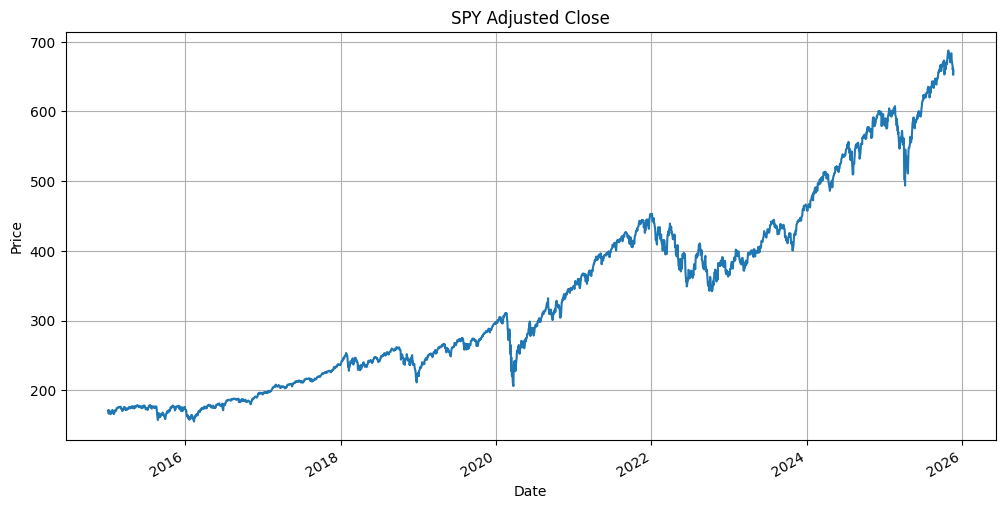

In [5]:
df_raw["price"].plot(title="SPY Adjusted Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

## 2. Add fast and slow EMAs

We now add a fast EMA and a slow EMA.

- Fast EMA reacts quickly to price moves.
- Slow EMA reacts more slowly and tracks the longer trend.

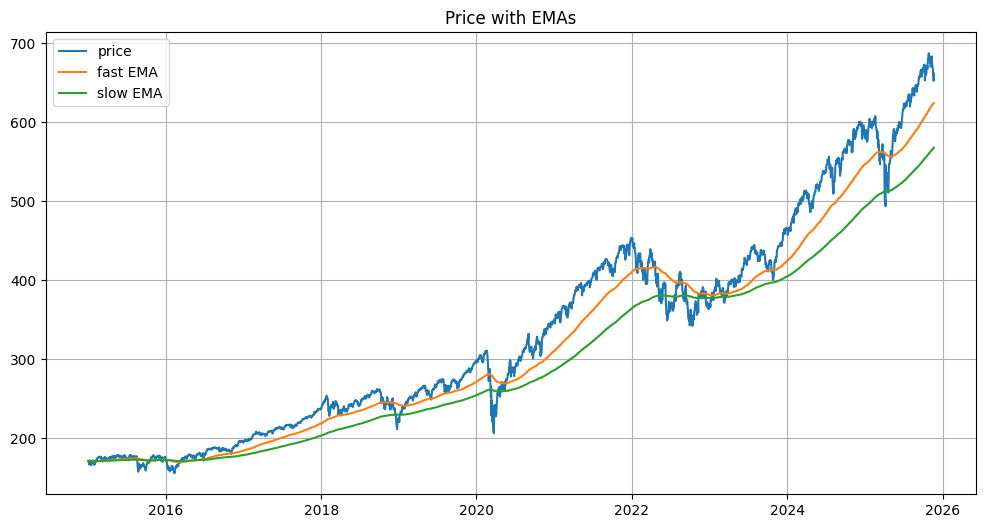

In [6]:
FAST = 200
SLOW = 500

df = add_ema_signals(df_raw, fast=FAST, slow=SLOW, long_short=False)
plot_price(df)

The orange line (fast EMA) hugs the price more closely than the green line (slow EMA). 
Crossovers between these two lines will drive our trading signals.

## 3. Trading signal and position

The strategy is:

- Go long when the fast EMA is above the slow EMA.
- Stay flat otherwise (for long-only mode).

To avoid lookahead bias, we shift the signal by one day so trades happen on the next bar.

In [7]:
df[["price", "ema_fast", "ema_slow", "signal", "position"]].head(15)

,price,ema_fast,ema_slow,signal,position
Date,,,,,
2015-01-02 00:00:00-05:00,171.093704,171.093704,171.093704,0,0.0
2015-01-05 00:00:00-05:00,168.003830,171.062959,171.081369,0,0.0
2015-01-06 00:00:00-05:00,166.421356,171.016774,171.062767,0,0.0
2015-01-07 00:00:00-05:00,168.495193,170.991684,171.052517,0,0.0
2015-01-08 00:00:00-05:00,171.485092,170.996593,171.054244,0,0.0
2015-01-09 00:00:00-05:00,170.110962,170.987781,171.050478,0,0.0
2015-01-12 00:00:00-05:00,168.778336,170.965796,171.041408,0,0.0
2015-01-13 00:00:00-05:00,168.303589,170.939307,171.030478,0,0.0
2015-01-14 00:00:00-05:00,167.287552,170.902971,171.015536,0,0.0


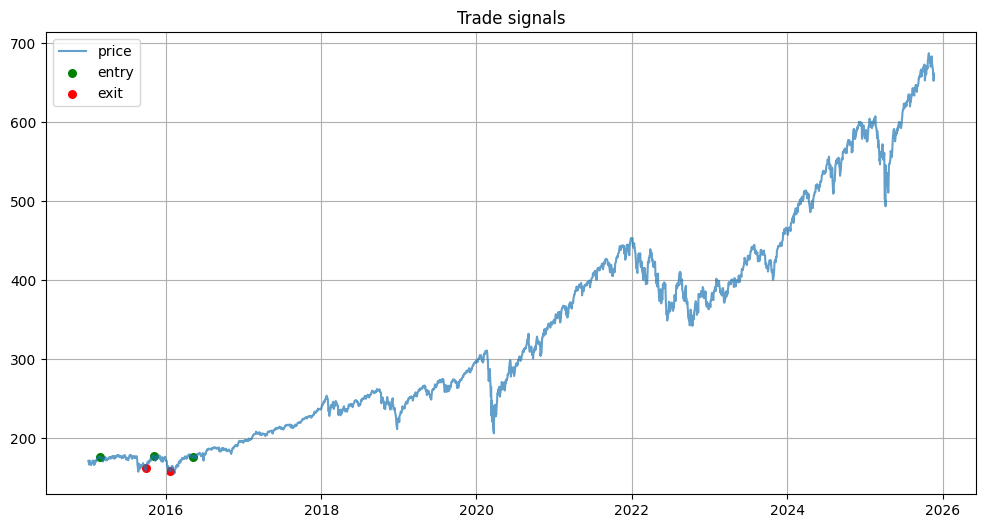

In [8]:
plot_signals(df)

Green dots mark entries where we move from no position to long.
Red dots mark exits where we close the long position.

## 4. Run backtest with trading costs

We now run the backtest for this EMA pair with:

- 0.1% cost per unit of position change,
- 2% annual risk-free rate for the Sharpe ratio.

In [9]:
COST_PER_TRADE = 0.001
ANNUAL_RF = 0.02

df_backtest, stats = run_backtest(
    df,
    cost_per_trade=COST_PER_TRADE,
    annual_rf=ANNUAL_RF,
)

stats

{'max_drawdown': np.float64(-0.33717260011763095),
 'total_return_strategy': np.float64(2.0288392901937233),
 'total_return_buy_hold': np.float64(2.851866041987565),
 'sharpe': np.float64(0.5560368840895974)}

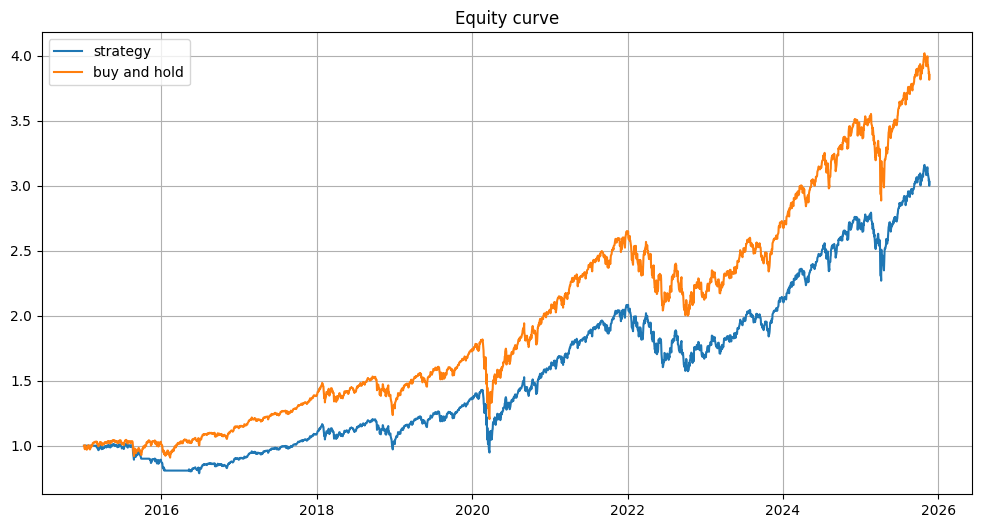

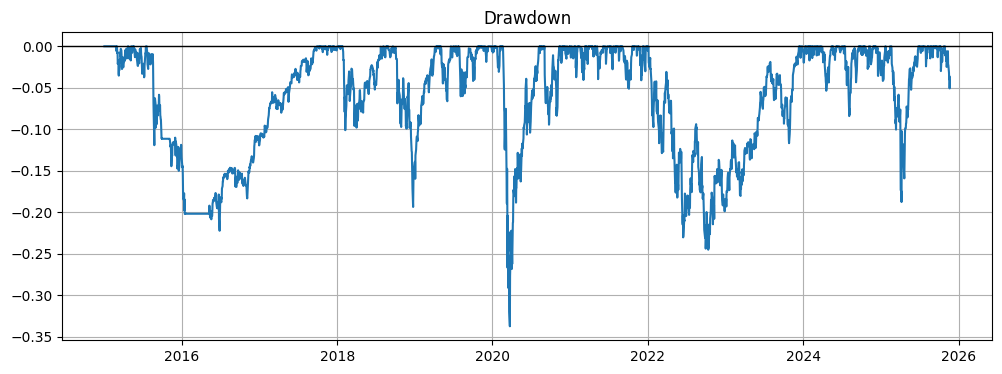

In [10]:
plot_equity(df_backtest)
plot_drawdown(df_backtest)

- `total_return_strategy` is the net return from following the EMA crossover with costs.
- `total_return_buy_hold` is what you get from holding SPY over the same period.
- `max_drawdown` shows the worst peak-to-trough drop.
- `sharpe` is the risk-adjusted return.

We can now change parameters and compare.

## 5. Long-only vs long/short

We compare:

- Long-only EMA crossover (1 when fast > slow, 0 otherwise).
- Long/short EMA crossover (1 when fast > slow, -1 when fast < slow).

In [11]:
def run_variant(fast, slow, long_short):
    df_var = add_ema_signals(df_raw, fast=fast, slow=slow, long_short=long_short)
    df_var, stats = run_backtest(
        df_var,
        cost_per_trade=COST_PER_TRADE,
        annual_rf=ANNUAL_RF,
    )
    return stats

pairs = [
    (12, 26),
    (50, 200),
    (500, 1000),
]

rows = []
for f, s in pairs:
    for long_short in [False, True]:
        stats = run_variant(f, s, long_short)
        rows.append({
            "fast": f,
            "slow": s,
            "long_short": long_short,
            **stats,
        })

results = pd.DataFrame(rows)
results

,fast,slow,long_short,max_drawdown,total_return_strategy,total_return_buy_hold,sharpe
0,12,26,False,-0.181881,1.134109,2.851866,0.515798
1,12,26,True,-0.407071,-0.068944,2.851866,-0.058227
2,50,200,False,-0.340159,0.925065,2.851866,0.347116
3,50,200,True,-0.544380,-0.151927,2.851866,-0.105792
4,500,1000,False,-0.337173,2.345335,2.851866,0.605058
5,500,1000,True,-0.337173,1.831577,2.851866,0.514979


In [12]:
results.sort_values("sharpe", ascending=False)

,fast,slow,long_short,max_drawdown,total_return_strategy,total_return_buy_hold,sharpe
4,500,1000,False,-0.337173,2.345335,2.851866,0.605058
0,12,26,False,-0.181881,1.134109,2.851866,0.515798
5,500,1000,True,-0.337173,1.831577,2.851866,0.514979
2,50,200,False,-0.340159,0.925065,2.851866,0.347116
1,12,26,True,-0.407071,-0.068944,2.851866,-0.058227
3,50,200,True,-0.544380,-0.151927,2.851866,-0.105792


### Observations

- Long-only versions tend to do better on SPY because the index has an upward drift.
- Long/short versions suffer when we short during local drops that quickly reverse.
- Slower EMAs trade less, so trading costs are smaller.

## 6. Parameter sweep over EMA pairs

Now that the backtest engine supports running many EMA pairs,
we can scan a small grid of `(fast, slow)` settings and compare
Sharpe, drawdown, and total return.

This is closer to how real strategy research is done.

In [13]:
# Reuse the raw SPY data we already loaded
df_raw = get_price_data("SPY", "2015-01-01")

fast_list = [5, 10, 20, 50]
slow_list = [50, 100, 200, 300]

# Long only here to avoid the issues we saw with shorting SPY
results_sweep = sweep_ema_params(
    df_raw=df_raw,
    fast_list=fast_list,
    slow_list=slow_list,
    long_short=False,
    cost_per_trade=0.001,
    annual_rf=0.02,
    trading_days=252,
)

results_sweep

,fast,slow,long_short,max_drawdown,total_return_strategy,total_return_buy_hold,sharpe
0,5,50,False,-0.185383,0.861548,2.851866,0.398953
1,5,100,False,-0.200088,1.511657,2.851866,0.628187
2,5,200,False,-0.269337,1.265113,2.851866,0.519116
3,5,300,False,-0.275769,1.240663,2.851866,0.481828
4,10,50,False,-0.153560,1.314699,2.851866,0.574700
5,10,100,False,-0.216625,1.727073,2.851866,0.689770
6,10,200,False,-0.292424,1.173993,2.851866,0.478095
7,10,300,False,-0.220695,1.550241,2.851866,0.566587
8,20,50,False,-0.263521,1.332777,2.851866,0.564308
9,20,100,False,-0.265156,1.200674,2.851866,0.503016


In [14]:
results_sweep.sort_values("sharpe", ascending=False)[
    ["fast", "slow", "sharpe", "max_drawdown", "total_return_strategy"]
].head(10)

,fast,slow,sharpe,max_drawdown,total_return_strategy
5,10,100,0.689770,-0.216625,1.727073
1,5,100,0.628187,-0.200088,1.511657
4,10,50,0.574700,-0.153560,1.314699
7,10,300,0.566587,-0.220695,1.550241
8,20,50,0.564308,-0.263521,1.332777
12,50,100,0.523354,-0.266684,1.369954
2,5,200,0.519116,-0.269337,1.265113
9,20,100,0.503016,-0.265156,1.200674
3,5,300,0.481828,-0.275769,1.240663
6,10,200,0.478095,-0.292424,1.173993


We can see which EMA pairs did best by Sharpe, and how that
relates to drawdown and total return. This also shows how
sensitive the strategy is to the choice of fast and slow window.

## 7. ATR filter and volatility based position sizing

Next, we use the ATR to measure daily volatility and:

1. Add an ATR column.
2. Filter out trades when ATR is below a threshold.
3. Scale position size based on ATR so that we target a more stable risk per day.

In [15]:
# Start from raw data again
df_raw = get_price_data("SPY", "2015-01-01")

# Step 1: add standard EMA signals (long only here)
df_atr = add_ema_signals(df_raw, fast=20, slow=100, long_short=False)

# Step 2: add ATR(14)
df_atr = add_atr(df_atr, n=14)

# Basic ATR filter: only trade when ATR is above its median
atr_threshold = df_atr["ATR"].median()
df_atr.loc[df_atr["ATR"] < atr_threshold, "signal"] = 0

# Step 3: use ATR based position sizing
df_atr = add_position_sizing(
    df_atr,
    risk_target=0.01,   # target 1 percent "risk" per ATR unit
    max_leverage=1.0,   # do not go above 1x
)

# Run backtest with new positions
df_atr_bt, stats_atr = run_backtest(
    df_atr,
    cost_per_trade=0.001,
    annual_rf=0.02,
)

stats_atr

{'max_drawdown': np.float64(-0.0004742413762793829),
 'total_return_strategy': np.float64(0.0007611016265474113),
 'total_return_buy_hold': np.float64(2.8518656984634907),
 'sharpe': np.float64(-125.83014021326464)}

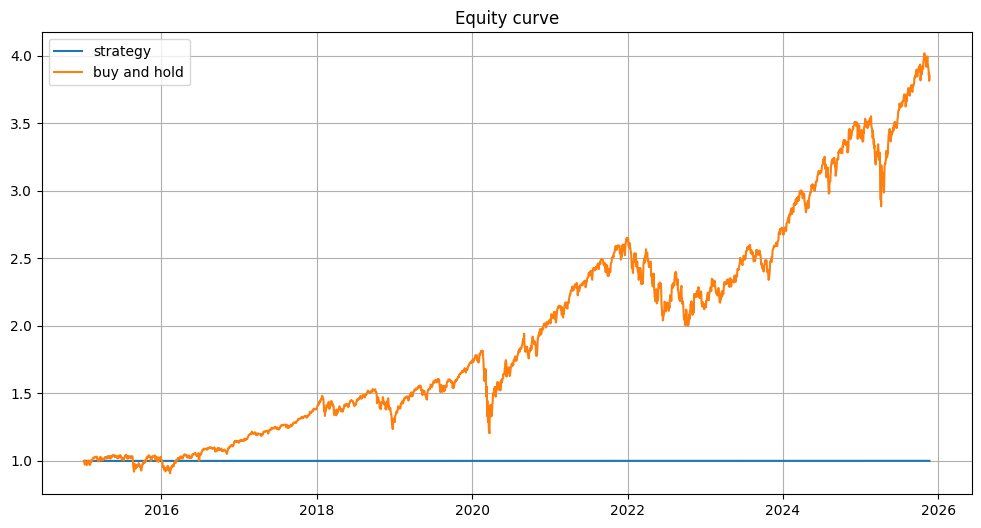

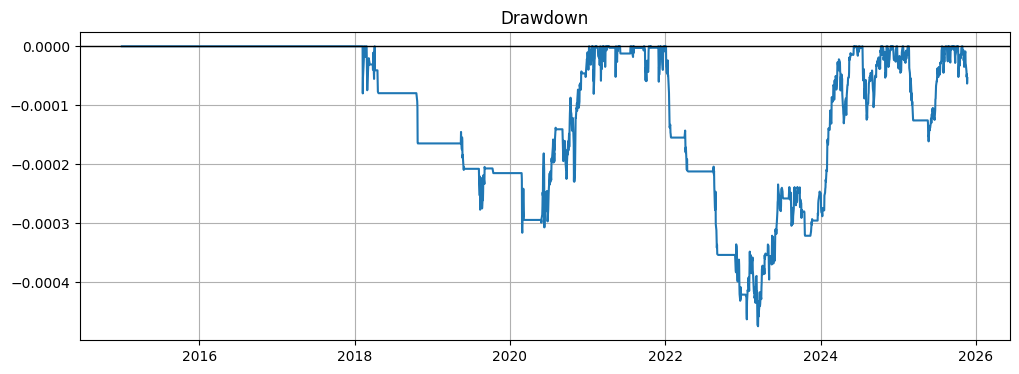

In [16]:
plot_equity(df_atr_bt)
plot_drawdown(df_atr_bt)

Here we used ATR to both filter trades and size positions.
The goal is to reduce trading in very quiet regimes and
avoid oversizing when volatility is high.

We can compare these stats and plots to the simpler fixed-size
EMA strategy from earlier.

## 8. Triple EMA trend filter

Finally, we use the triple EMA version of the strategy.

We define three EMAs:

- fast
- mid
- slow

We only go long when `fast > mid > slow` which means a strong, aligned uptrend.
If we allow long/short, we can also short when `fast < mid < slow`.


In [17]:
df_raw = get_price_data("SPY", "2015-01-01")

# Triple EMA with long only
df_triple = add_triple_ema_signals(
    df_raw,
    fast=10,
    mid=50,
    slow=200,
    long_short=False,
)

df_triple_bt, stats_triple = run_backtest(
    df_triple,
    cost_per_trade=0.001,
    annual_rf=0.02,
)

stats_triple

{'max_drawdown': np.float64(-0.18461192603630883),
 'total_return_strategy': np.float64(0.7211315666795379),
 'total_return_buy_hold': np.float64(2.8518656984634907),
 'sharpe': np.float64(0.34687986660511033)}

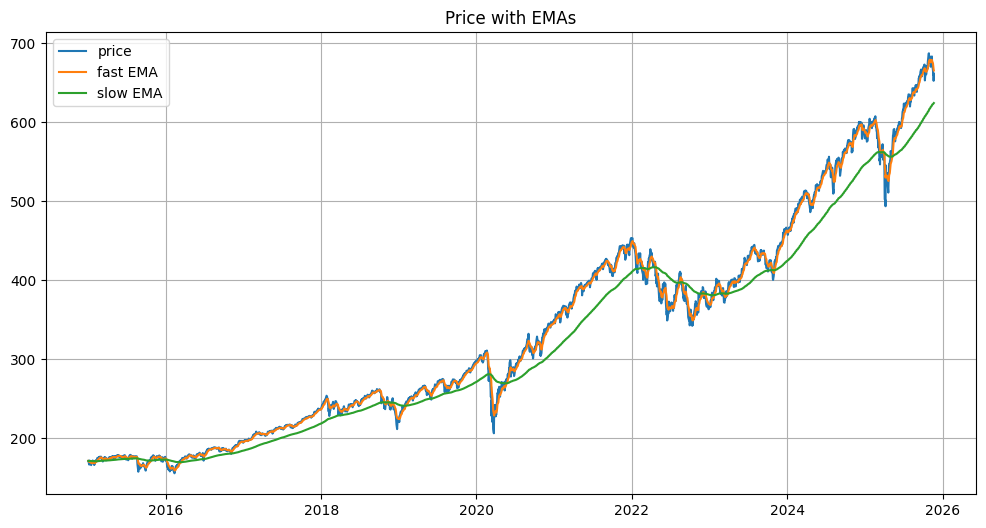

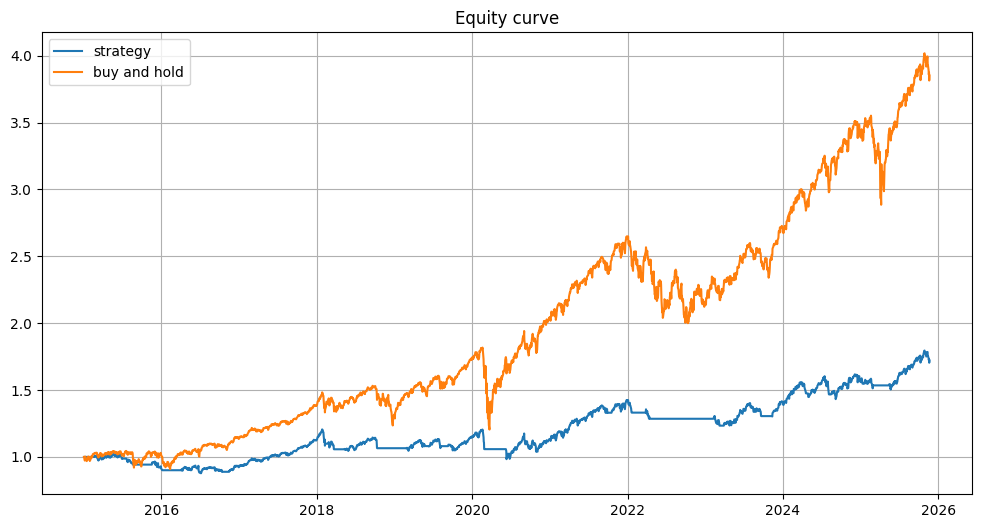

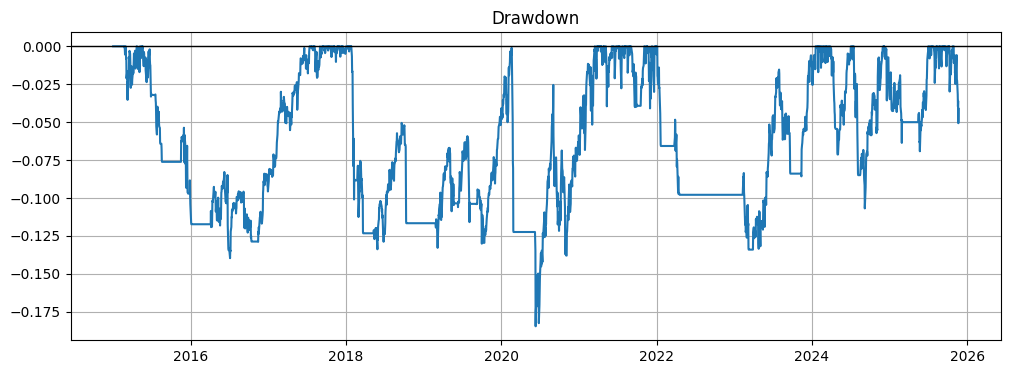

In [18]:
plot_price(df_triple_bt)   # shows fast/mid/slow with price
plot_equity(df_triple_bt)
plot_drawdown(df_triple_bt)

The triple EMA rules give fewer but cleaner signals.
We trade less, which also reduces trading costs.

We can now compare this with the basic two-EMA crossover and see
how the trade-off between signal frequency and trend strength looks.

## 9. Simple walk-forward test

Here we:

1. Use data up to the end of 2019 to choose the best EMA pair.
2. Then test that pair on data from 2020 onward.

In [19]:
df_raw = get_price_data("SPY", "2015-01-01")

fast_list = [5, 10, 20, 50]
slow_list = [50, 100, 200, 300]

df_test_bt, test_stats, train_results = walk_forward_once(
    df_raw=df_raw,
    train_end="2019-12-31",
    fast_list=fast_list,
    slow_list=slow_list,
    long_short=False,
    cost_per_trade=0.001,
    annual_rf=0.02,
)

test_stats

{'max_drawdown': np.float64(-0.2225014633725304),
 'total_return_strategy': np.float64(0.6542242925976844),
 'total_return_buy_hold': np.float64(1.2278661016643175),
 'sharpe': np.float64(0.5483400841632339)}

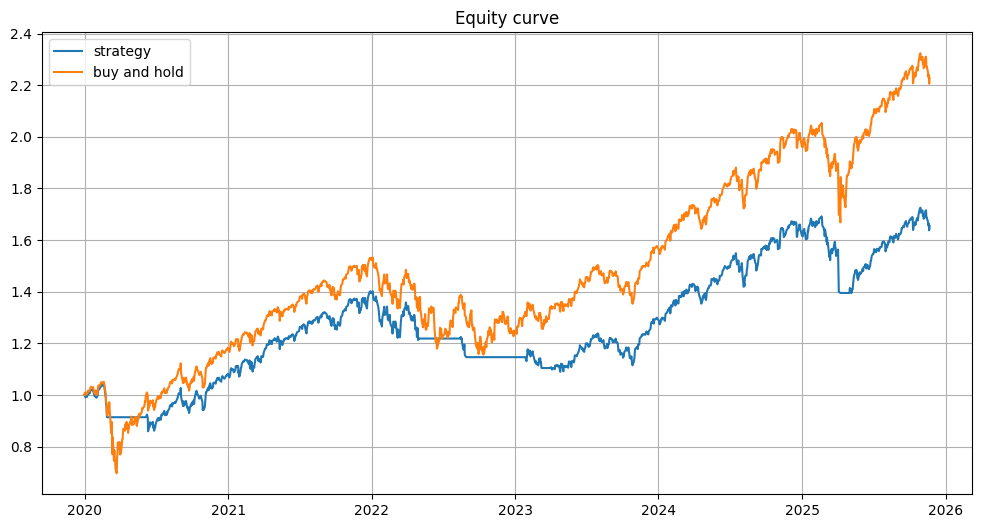

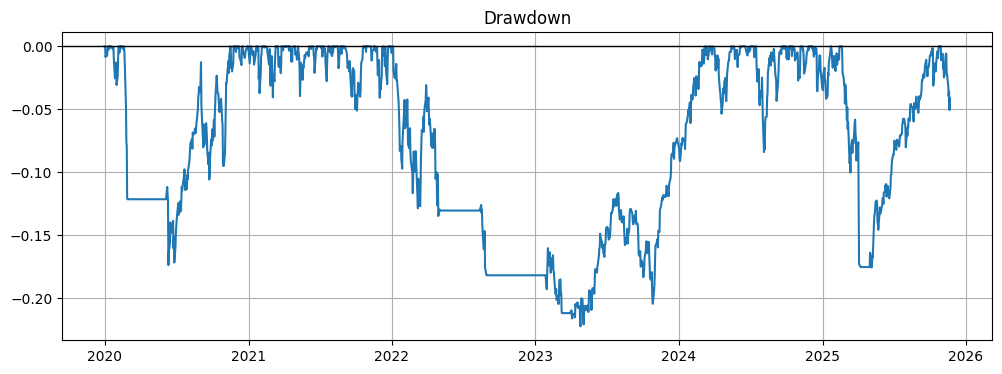

In [20]:
plot_equity(df_test_bt)
plot_drawdown(df_test_bt)

This gives a simple example of using a training period
to pick parameters and then evaluating them on a separate
test period, instead of tuning on the full history.

# Closing Reflection

Working through this backtest made the process feel real instead of abstract.
Building each step by hand showed me how much of trading is just careful bookkeeping.
Daily returns, position changes, and costs decide most of the outcome, not the signal itself.

I also saw that simple ideas only look simple from far away.
Once I added costs, signals, sizing, and testing rules, the results changed a lot.
Small choices, like shifting the signal or picking slower EMAs, had a big impact.
This helped me understand why good strategy work needs clear rules and clean data.

Trying different EMA pairs taught me that testing one setup is not enough.
Some pairs looked strong until I looked at Sharpe or drawdown.
Seeing how the strategy behaved across many choices made the pattern clearer.

Adding ATR and triple EMAs showed me that filters and sizing matter as much as the main rule.
They remove noise and keep the risk steady.
These parts are simple, but they change the feel of the strategy a lot.

Doing a small walk-forward test gave me a better sense of how to avoid fooling myself.
Picking settings on one period and checking them on another made it easier to spot overfitting.

Overall, this project helped me see how to think through a full strategy, not just code one.
I started with one crossover, and ended with a small engine that can test many ideas.
This gives me a better base for more advanced work later.